In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
import tensorflow
from sklearn.ensemble import RandomForestClassifier
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_fieldtrip, RawArray
from mne.datasets import eegbci
from mne.decoding import CSP, Scaler
from mne import viz
from mne import create_info, find_events
from fieldtrip2mne import read_raw
import scipy as sc
from scipy.io import loadmat
from scipy.signal import welch
from mne.channels import make_standard_montage, get_builtin_montages
from mne.viz.topomap import plot_topomap
from sklearn.model_selection import train_test_split
from sklearn import svm
from tkinter.tix import InputOnly
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Embedding, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from keras.utils import *
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.fft import fft, fftfreq, fftshift
import time

# Data preparation

In [50]:
# Labels data for use by lining up event IDs and their indexes with the sensor data
def LabelEEG(dataset,type):
    data_set = loadmat(dataset)
    rows = data_set['info']
    actualrows = rows['label']
    dataVal = data_set['eeg']
    i = 0
    finalrows={}
    b = actualrows[0][0][0]
    for v in b:
        finalrows[i]=v[0]
        i = i+1
    data = dataVal.transpose()
    df = pd.DataFrame(data=data, columns=finalrows.values())
    if type == 1:
        hertzOrder = [4,2,3,5,1,2,5,4,2,3,1,5]
    else:
        hertzOrder = [4,3,2,4,1,2,5,3,4,1,3,1,3]
    indexNum=0
    hertzNum=0
    events=data_set['events']
    labelList=[0]*len(df.index)
    df['Label']= labelList
    for i in events:
        if i[1] == 32779:
            df.iloc[indexNum:i[2],15] = 0
            indexNum = i[2]
        if i[1] == 32780:
            df.iloc[indexNum:i[2],15] = hertzOrder[hertzNum]
            indexNum = i[2]
            hertzNum+=1
    return df


In [51]:
# This code block ran through all the data, labelled each row and collated them into one big dataframe, which was then saved as a csv file. We will use this csv file for the ML models  
datasets = ['EEG-SSVEP-Experiment3/U001ai.mat','EEG-SSVEP-Experiment3/U001aii.mat','EEG-SSVEP-Experiment3/U001bi.mat','EEG-SSVEP-Experiment3/U001bii.mat','EEG-SSVEP-Experiment3/U001ci.mat','EEG-SSVEP-Experiment3/U001cii.mat','EEG-SSVEP-Experiment3/U001di.mat','EEG-SSVEP-Experiment3/U001dii.mat','EEG-SSVEP-Experiment3/U001ei.mat','EEG-SSVEP-Experiment3/U001eii.mat','EEG-SSVEP-Experiment3/U002ai.mat','EEG-SSVEP-Experiment3/U002aii.mat','EEG-SSVEP-Experiment3/U002bi.mat','EEG-SSVEP-Experiment3/U002bii.mat','EEG-SSVEP-Experiment3/U002ci.mat','EEG-SSVEP-Experiment3/U002cii.mat','EEG-SSVEP-Experiment3/U002di.mat','EEG-SSVEP-Experiment3/U002dii.mat','EEG-SSVEP-Experiment3/U002ei.mat','EEG-SSVEP-Experiment3/U002eii.mat','EEG-SSVEP-Experiment3/U003ai.mat','EEG-SSVEP-Experiment3/U003aii.mat','EEG-SSVEP-Experiment3/U003bi.mat','EEG-SSVEP-Experiment3/U003bii.mat','EEG-SSVEP-Experiment3/U003ci.mat','EEG-SSVEP-Experiment3/U003cii.mat','EEG-SSVEP-Experiment3/U003di.mat','EEG-SSVEP-Experiment3/U003dii.mat','EEG-SSVEP-Experiment3/U003ei.mat','EEG-SSVEP-Experiment3/U003eii.mat','EEG-SSVEP-Experiment3/U004ai.mat','EEG-SSVEP-Experiment3/U004aii.mat','EEG-SSVEP-Experiment3/U004bi.mat','EEG-SSVEP-Experiment3/U004bii.mat','EEG-SSVEP-Experiment3/U004ci.mat','EEG-SSVEP-Experiment3/U004cii.mat','EEG-SSVEP-Experiment3/U004di.mat','EEG-SSVEP-Experiment3/U004dii.mat','EEG-SSVEP-Experiment3/U004ei.mat','EEG-SSVEP-Experiment3/U004eii.mat','EEG-SSVEP-Experiment3/U005ai.mat','EEG-SSVEP-Experiment3/U005aii.mat','EEG-SSVEP-Experiment3/U005bi.mat','EEG-SSVEP-Experiment3/U005bii.mat','EEG-SSVEP-Experiment3/U005ci.mat','EEG-SSVEP-Experiment3/U005cii.mat','EEG-SSVEP-Experiment3/U005di.mat','EEG-SSVEP-Experiment3/U005dii.mat','EEG-SSVEP-Experiment3/U005ei.mat','EEG-SSVEP-Experiment3/U005eii.mat','EEG-SSVEP-Experiment3/U006ai.mat','EEG-SSVEP-Experiment3/U006aii.mat','EEG-SSVEP-Experiment3/U006bi.mat','EEG-SSVEP-Experiment3/U006bii.mat','EEG-SSVEP-Experiment3/U006ci.mat','EEG-SSVEP-Experiment3/U006cii.mat','EEG-SSVEP-Experiment3/U006di.mat','EEG-SSVEP-Experiment3/U006dii.mat','EEG-SSVEP-Experiment3/U006ei.mat','EEG-SSVEP-Experiment3/U006eii.mat','EEG-SSVEP-Experiment3/U007ai.mat','EEG-SSVEP-Experiment3/U007aii.mat','EEG-SSVEP-Experiment3/U007bi.mat','EEG-SSVEP-Experiment3/U007bii.mat','EEG-SSVEP-Experiment3/U007ci.mat','EEG-SSVEP-Experiment3/U007cii.mat','EEG-SSVEP-Experiment3/U007di.mat','EEG-SSVEP-Experiment3/U007dii.mat','EEG-SSVEP-Experiment3/U007ei.mat','EEG-SSVEP-Experiment3/U007eii.mat','EEG-SSVEP-Experiment3/U008ai.mat','EEG-SSVEP-Experiment3/U008aii.mat','EEG-SSVEP-Experiment3/U008bi.mat','EEG-SSVEP-Experiment3/U008bii.mat','EEG-SSVEP-Experiment3/U008ci.mat','EEG-SSVEP-Experiment3/U008cii.mat','EEG-SSVEP-Experiment3/U008di.mat','EEG-SSVEP-Experiment3/U008dii.mat','EEG-SSVEP-Experiment3/U008ei.mat','EEG-SSVEP-Experiment3/U008eii.mat','EEG-SSVEP-Experiment3/U009ai.mat','EEG-SSVEP-Experiment3/U009aii.mat','EEG-SSVEP-Experiment3/U009bi.mat','EEG-SSVEP-Experiment3/U009bii.mat','EEG-SSVEP-Experiment3/U009ci.mat','EEG-SSVEP-Experiment3/U009cii.mat','EEG-SSVEP-Experiment3/U009di.mat','EEG-SSVEP-Experiment3/U009dii.mat','EEG-SSVEP-Experiment3/U009ei.mat','EEG-SSVEP-Experiment3/U009eii.mat','EEG-SSVEP-Experiment3/U010ai.mat','EEG-SSVEP-Experiment3/U010aii.mat','EEG-SSVEP-Experiment3/U010bi.mat','EEG-SSVEP-Experiment3/U010bii.mat','EEG-SSVEP-Experiment3/U010ci.mat','EEG-SSVEP-Experiment3/U010cii.mat','EEG-SSVEP-Experiment3/U010di.mat','EEG-SSVEP-Experiment3/U010dii.mat','EEG-SSVEP-Experiment3/U010ei.mat','EEG-SSVEP-Experiment3/U010eii.mat','EEG-SSVEP-Experiment3/U011ai.mat','EEG-SSVEP-Experiment3/U011aii.mat','EEG-SSVEP-Experiment3/U011bi.mat','EEG-SSVEP-Experiment3/U011bii.mat','EEG-SSVEP-Experiment3/U011ci.mat','EEG-SSVEP-Experiment3/U011cii.mat','EEG-SSVEP-Experiment3/U011di.mat','EEG-SSVEP-Experiment3/U011dii.mat','EEG-SSVEP-Experiment3/U011ei.mat','EEG-SSVEP-Experiment3/U011eii.mat']
# datasets = ['EEG-SSVEP-Experiment3/U001ai.mat','EEG-SSVEP-Experiment3/U001aii.mat','EEG-SSVEP-Experiment3/U001bi.mat','EEG-SSVEP-Experiment3/U001bii.mat','EEG-SSVEP-Experiment3/U001ci.mat','EEG-SSVEP-Experiment3/U001cii.mat','EEG-SSVEP-Experiment3/U001di.mat','EEG-SSVEP-Experiment3/U001dii.mat','EEG-SSVEP-Experiment3/U001ei.mat','EEG-SSVEP-Experiment3/U001eii.mat']
numbers = [1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2]
count = 0
df1 = LabelEEG(datasets[count], numbers[count])
count = 1
while count < len(datasets):
    df2 = LabelEEG(datasets[count], numbers[count])
    count = count+1
    df1 = pd.concat([df1, df2], axis=0)
# Perform feature importance listing
model = DecisionTreeClassifier()
# fit the dataset so we can rank inportance
model = model.fit(df1.values[:,0:15],df1.values[:,15])
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# Drop unnecessary Status column
df1 = df1.drop(['Status'], axis=1)
# df1 = df1[df1['Label'] > 0]
df1.iloc[:,0:14] = df1.iloc[:,0:14].div(1000)
df1.to_csv('fullEEGdataset.csv',index=False)

Feature: 0, Score: 0.07571
Feature: 1, Score: 0.07086
Feature: 2, Score: 0.06973
Feature: 3, Score: 0.06890
Feature: 4, Score: 0.07350
Feature: 5, Score: 0.07339
Feature: 6, Score: 0.07197
Feature: 7, Score: 0.06697
Feature: 8, Score: 0.07283
Feature: 9, Score: 0.06434
Feature: 10, Score: 0.06777
Feature: 11, Score: 0.08037
Feature: 12, Score: 0.06855
Feature: 13, Score: 0.07475
Feature: 14, Score: 0.00038


In [4]:
# Butterworth bandpass values setup
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Butterworth bandpass filters at the 5th order
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating RawArray with float64 data, n_channels=15, n_times=2118528
    Range : 0 ... 2118527 =      0.000 ... 16550.992 secs
Ready.


<RawArray | 15 x 2118528 (16551.0 s), ~242.5 MB, data loaded>

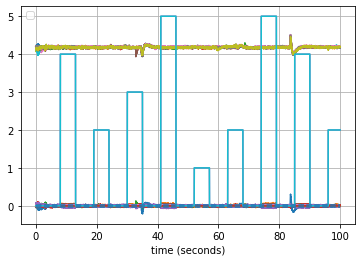

In [5]:
# Creates and specifies an MNE info object with hold sensor data and locations
decim = 2
sfreq = float(128)
montage = make_standard_montage('standard_1005')
theInfo = create_info(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4','Label'],sfreq,ch_types=['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','stim'],verbose=None)
# Reads previously saved csv dataset
df1 = pd.read_csv('fullEEGdataset.csv')
x = df1.to_numpy()
# Creates spare copy for comparison
df4 = df1.copy()
# 5th order butterpass filter, as part of data preprocessing
fs = 128
lowcut = 4.0
highcut = 30.0
filtered = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)
# PCA to ensure readability by later CSP modules, and some light feature extraction
pca = PCA(n_components=14)
filtered = pca.fit_transform(filtered)
df1.iloc[:,0:14] = pd.DataFrame(filtered).iloc[:,0:14]
# Transposing the dataset to suit MNE's needs
data = df1.values.transpose()
# Plotting both the filtered and original data for comparison
t = np.linspace(0, 100, 12800, endpoint=False)
plt.plot(t, df1.values[0:12800])
plt.plot(t, df4.values[0:12800])
plt.xlabel('time (seconds)')
plt.hlines([-0.02, 0.02], 0, 100, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
# Saving the plot
plt.savefig('Figures/Fig1_FilterComparison.svg',bbox_inches='tight')
# Find NaN values in Dataset
nulls = df1.isnull().sum()
# Find Infinite values in the dataset
infs = df1.isin([np.inf, -np.inf]).sum()
# Output shows no infinite or missing data
# Creating an MNE raw object which will allow for event and epoch creation
raw = RawArray(data, theInfo)
raw.set_montage('standard_1005')

2750 events found
Event IDs: [0 1 2 3 4 5]
Not setting metadata
1375 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1375 events and 244 original time points ...
0 bad epochs dropped
Not setting metadata
275 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


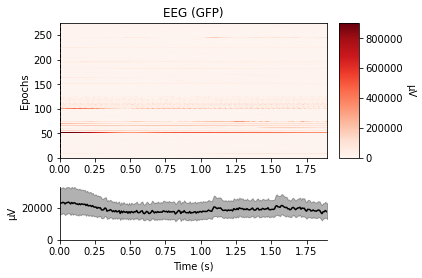

In [6]:
# Defines and creates events based off the label feature
event_id = dict(hz12=1, hz10=2, hz857=3, hz750=4, hz666=5)
events = find_events(raw, stim_channel='Label',output='step',initial_event=False,shortest_event=10)
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

# Testing will be done with a running classifier, therefore the dataset is broken up into trials
epochs = Epochs(raw, events, event_id, tmin=0, tmax=1.9, proj=True, picks=picks,
                baseline=None, preload=True)
# shows a visualisation of the 12Hz event data
figure = plt.figure(epochs['hz12'].plot_image(show=False)[0])
# saves plot
figure.savefig('Figures/Fig2_12HzVisualisation.svg',bbox_inches='tight')
# split data into x and y for training
y = epochs.events[:, -1]
X =  epochs.get_data()
trials=1375

# CSP + LSTM

Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 14 dim * 3.7e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.16 (2.2e-16 eps * 14 dim * 5.3e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.17 (2.2e-16 eps * 14 dim * 5.4e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 14 dim * 6.6e+13  max singular value)
    Estimate

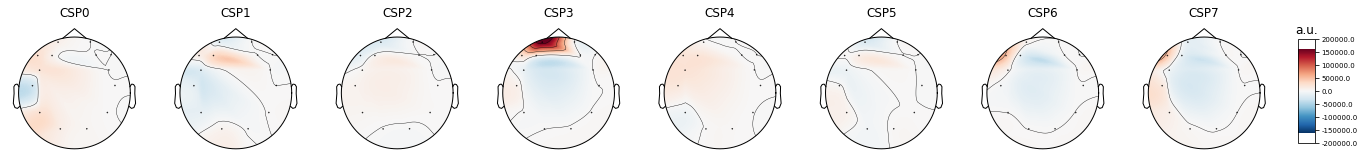

In [55]:
# CSP
num_components = 8
csp = CSP(n_components=num_components, reg=None, log=None, norm_trace=False,cov_est='concat',transform_into='csp_space')
# Fit and transform CSP values
csp.fit(X,y)
S = csp.transform(X)
# Show and save plot of CSP patterning
figure = plt.figure(csp.plot_patterns(epochs.info, ch_type='eeg', size=1.5,show=False))
figure.savefig('Figures/Fig3_CSPpatternplots.svg',bbox_inches='tight')
# LSTM
timesteps = 244  
channels_num = 14
S = np.reshape(S,(trials,timesteps,num_components))
# Splitting the dataset
S_train, S_test, y_train, y_test = train_test_split(S,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
model = Sequential()
# Setup LSTM model
model.add(LSTM(128,input_shape=(timesteps,num_components),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,input_shape=(timesteps,num_components),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train dataset
model.fit(S_train,ynew,epochs=100,verbose=1,validation_split=0.2)
# Test dataset
tic = time.perf_counter()
predicted = model.predict(S_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper

scores = []
# Extract prediction values

for predict in predicted:
    scores.append(np.argmax(predict))
# Exctract and save output metrics
output = "Results for CSP + LSTM\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(scores,y_test-1)) +'\n'
output = output + str(classification_report(scores,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

# CSP + SVM

Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 14 dim * 3.7e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.16 (2.2e-16 eps * 14 dim * 5.3e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.17 (2.2e-16 eps * 14 dim * 5.4e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 14 dim * 6.6e+13  max singular value)
    Estimate

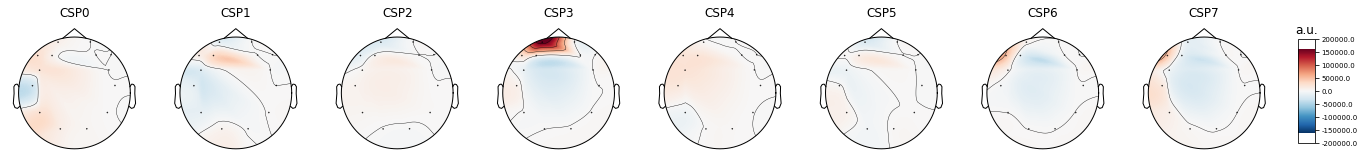

In [7]:
# CSP
num_components = 8
csp = CSP(n_components=num_components, reg=None, log=None, norm_trace=False,cov_est='concat',transform_into='csp_space')
# Fit and transform CSP values
csp.fit(X,y)
S = csp.transform(X)
# Show and save pattern plots
figure = plt.figure(csp.plot_patterns(epochs.info, ch_type='eeg', size=1.5,show=False))
figure.savefig('Figures/Fig3_CSPpatternplots.svg',bbox_inches='tight')
# SVM
timesteps = 244  
channels_num = 14
# Reshape dataset from 3d to 2d
S = np.reshape(S,(trials,timesteps*num_components))
# Split dataset
S_train, S_test, y_train, y_test = train_test_split(S,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
model = svm.SVC(kernel='rbf',max_iter=-1, probability=True)
# Train model
model.fit(S_train,ynew)
# Test model
tic = time.perf_counter()
predicted = model.predict(S_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
# Exctract and save output metrics
output = "Results for CSP + SVM\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(predicted,y_test-1)) +'\n'
output = output + str(classification_report(predicted,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

# CSP + RandomForestClassifier

Computing rank from data with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 14 dim * 3.7e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.16 (2.2e-16 eps * 14 dim * 5.3e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.17 (2.2e-16 eps * 14 dim * 5.4e+13  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 14 dim * 6.6e+13  max singular value)
    Estimate

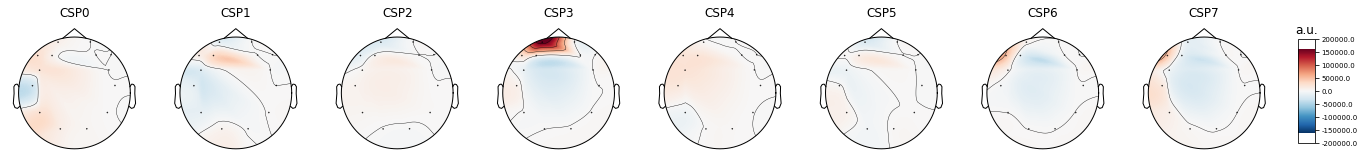

Results for CSP + RandomForestClassifier

Confusion Matrix
[[55  0  0  0  0]
 [ 0 55  0  0  0]
 [ 0  0 66  0  0]
 [ 0  0  0 55  0]
 [ 0  0  0  0 44]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        66
           3       1.00      1.00      1.00        55
           4       1.00      1.00      1.00        44

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

FPS: 13330.435850089169FPS




In [57]:
# CSP
num_components = 8
csp = CSP(n_components=num_components, reg=None, log=None, norm_trace=False,cov_est='concat',transform_into='csp_space')
# Fit and transform CSP values
csp.fit(X,y)
S = csp.transform(X)
figure = plt.figure(csp.plot_patterns(epochs.info, ch_type='eeg', size=1.5,show=False))
figure.savefig('Figures/Fig3_CSPpatternplots.svg',bbox_inches='tight')
# LSTM
timesteps = 244  
channels_num = 14
# Reshaping the dataset to 2d from 3d
S = np.reshape(S,(trials,timesteps*num_components))
# Splitting the dataset
S_train, S_test, y_train, y_test = train_test_split(S,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
# RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)
# Train model
model.fit(S_train,ynew)
# Test model
tic = time.perf_counter()
predicted = model.predict(S_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
# Exctract and save output metrics
output = "Results for CSP + RandomForestClassifier\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(predicted,y_test-1)) +'\n'
output = output + str(classification_report(predicted,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

# LSTM (No feature extraction)

In [58]:

num_components = 14
timesteps = 244  
channels_num = 14
Xnew = np.transpose(X,(0,2,1)).copy()
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(Xnew,y,test_size=0.2,shuffle=True,stratify=y)
model = Sequential()
# Set up LSTM model
model.add(LSTM(128,input_shape=(timesteps,num_components),return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64,input_shape=(timesteps,num_components),return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
model.fit(X_train,y_train-1,epochs=100,verbose=1,validation_split=0.2)
# Test model
tic = time.perf_counter()
predicted = model.predict(X_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
scores = []
# Extract prediction values
for predict in predicted:
    scores.append(np.argmax(predict))
# Exctract and save output metrics
output = "Results for LSTM (nothing after PCA)\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(scores,y_test-1)) +'\n'
output = output + str(classification_report(scores,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

Epoch 1/100
28/28 [==============================] - 10s 254ms/step - loss: 1.4867 - accuracy: 0.3205 - val_loss: 1.4876 - val_accuracy: 0.3091
Epoch 2/100
28/28 [==============================] - 6s 231ms/step - loss: 1.5891 - accuracy: 0.2591 - val_loss: 1.5996 - val_accuracy: 0.1864
Epoch 3/100
28/28 [==============================] - 6s 226ms/step - loss: 1.5903 - accuracy: 0.2386 - val_loss: 1.5840 - val_accuracy: 0.2591
Epoch 4/100
28/28 [==============================] - 6s 228ms/step - loss: 1.4195 - accuracy: 0.3261 - val_loss: 1.2808 - val_accuracy: 0.4091
Epoch 5/100
28/28 [==============================] - 7s 234ms/step - loss: 1.2926 - accuracy: 0.4193 - val_loss: 1.2880 - val_accuracy: 0.3864
Epoch 6/100
28/28 [==============================] - 6s 233ms/step - loss: 1.2700 - accuracy: 0.4045 - val_loss: 1.3184 - val_accuracy: 0.4045
Epoch 7/100
28/28 [==============================] - 7s 237ms/step - loss: 1.2763 - accuracy: 0.4205 - val_loss: 1.3196 - val_accuracy: 0.404

# SVM (No feature extraction)

In [59]:
timesteps = 244  
channels_num = 14
# Reshaping the dataset to 2d from 3d
Xnew = np.reshape(X.copy(),(trials,timesteps*channels_num))
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(Xnew,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
# SVM
model = svm.SVC(kernel='rbf',max_iter=-1, probability=True)
# Train model
model.fit(X_train,ynew)
# Test model
tic = time.perf_counter()
predicted = model.predict(X_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
# Exctract and save output metrics
output = "Results for SVM (nothing after PCA)\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(predicted,y_test-1)) +'\n'
output = output + str(classification_report(predicted,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

Results for SVM (nothing after PCA)

Confusion Matrix
[[54  3  0  1  0]
 [ 0 49  1  0  0]
 [ 0  2 60  1  0]
 [ 1  1  5 52  2]
 [ 0  0  0  1 42]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        58
           1       0.89      0.98      0.93        50
           2       0.91      0.95      0.93        63
           3       0.95      0.85      0.90        61
           4       0.95      0.98      0.97        43

    accuracy                           0.93       275
   macro avg       0.94      0.94      0.94       275
weighted avg       0.94      0.93      0.93       275

FPS: 1868.5668416710814FPS




# RandomForestClassifier (No feature extraction)

In [60]:

timesteps = 244  
channels_num = 14
# Reshaping the dataset to 2d from 3d
Xnew = np.reshape(X.copy(),(trials,timesteps*channels_num))
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(Xnew,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
# RandomForestClassifier model
model = RandomForestClassifier(n_estimators=1000)
# Train model
model.fit(X_train,ynew)
# Test model
tic = time.perf_counter()
predicted = model.predict(X_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
# Exctract and save output metrics
output = "Results for RandomForestClassifier (nothing after PCA)\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(predicted,y_test-1)) +'\n'
output = output + str(classification_report(predicted,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

Results for RandomForestClassifier (nothing after PCA)

Confusion Matrix
[[51  2  0  1  0]
 [ 2 52  3  0  1]
 [ 2  0 60  3  0]
 [ 0  1  3 51  3]
 [ 0  0  0  0 40]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        54
           1       0.95      0.90      0.92        58
           2       0.91      0.92      0.92        65
           3       0.93      0.88      0.90        58
           4       0.91      1.00      0.95        40

    accuracy                           0.92       275
   macro avg       0.92      0.93      0.93       275
weighted avg       0.92      0.92      0.92       275

FPS: 11434.14364739026FPS




# FFT + LSTM

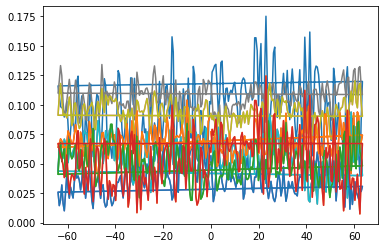

C:\Users\seanh\AppData\Local\Temp\ipykernel_17760\2540693833.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Xfft[i] = fft(Xnew[i])


Epoch 1/100
28/28 [==============================] - 11s 266ms/step - loss: 1.4954 - accuracy: 0.3182 - val_loss: 1.1966 - val_accuracy: 0.3545
Epoch 2/100
28/28 [==============================] - 6s 216ms/step - loss: 1.1368 - accuracy: 0.4432 - val_loss: 1.1084 - val_accuracy: 0.5318
Epoch 3/100
28/28 [==============================] - 6s 218ms/step - loss: 1.0660 - accuracy: 0.6023 - val_loss: 0.9262 - val_accuracy: 0.6955
Epoch 4/100
28/28 [==============================] - 6s 222ms/step - loss: 0.7453 - accuracy: 0.6955 - val_loss: 0.5900 - val_accuracy: 0.8591
Epoch 5/100
28/28 [==============================] - 6s 218ms/step - loss: 0.5597 - accuracy: 0.8261 - val_loss: 0.4779 - val_accuracy: 0.8500
Epoch 6/100
28/28 [==============================] - 6s 228ms/step - loss: 0.6303 - accuracy: 0.7557 - val_loss: 0.4841 - val_accuracy: 0.9364
Epoch 7/100
28/28 [==============================] - 6s 224ms/step - loss: 0.4173 - accuracy: 0.9239 - val_loss: 0.4848 - val_accuracy: 0.790

In [61]:
# FFT
timesteps = 244 
Xnew = np.transpose(X,(0,2,1)).copy()
# Get FFT
yf = fft(Xnew[0])
xf = fftfreq(timesteps, 1 / 128)
plt.plot(xf, np.abs(yf))
plt.savefig('Figures/Fig4_FFTtransformedsample.svg',bbox_inches='tight')
plt.show()
Xfft = Xnew.copy()
for i in range(0, trials):
    Xfft[i] = fft(Xnew[i])
num_components = 14
channels_num = 14
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(Xfft,y,test_size=0.2,shuffle=True,stratify=y)
model = Sequential()
# Setup LSTM model
model.add(LSTM(128,input_shape=(timesteps,num_components),return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64,input_shape=(timesteps,num_components),return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
model.fit(X_train,y_train-1,epochs=100,verbose=1,validation_split=0.2)
# Test model
tic = time.perf_counter()
predicted = model.predict(X_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
scores = []
for predict in predicted:
    scores.append(np.argmax(predict))
# Exctract and save output metrics
output = "Results for FFT + LSTM\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(scores,y_test-1)) +'\n'
output = output + str(classification_report(scores,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

# FFT + SVM

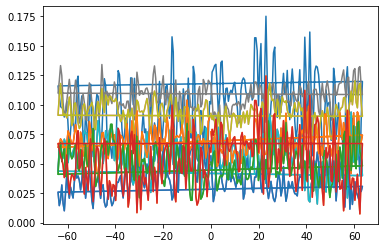

C:\Users\seanh\AppData\Local\Temp\ipykernel_17760\1009656384.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Xfft[i] = fft(Xnew[i])


(1375, 244, 14)
Results for FFT + SVM

Confusion Matrix
[[51  2  0  0  0]
 [ 2 50  1  0  0]
 [ 0  0 60  2  0]
 [ 2  3  5 52  4]
 [ 0  0  0  1 40]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        53
           1       0.91      0.94      0.93        53
           2       0.91      0.97      0.94        62
           3       0.95      0.79      0.86        66
           4       0.91      0.98      0.94        41

    accuracy                           0.92       275
   macro avg       0.92      0.93      0.92       275
weighted avg       0.92      0.92      0.92       275

FPS: 1893.2533737460487FPS




In [62]:
# FFT
timesteps = 244 
Xnew = np.transpose(X,(0,2,1)).copy()
# Get FFT values and perform transformation
yf = fft(Xnew[0])
xf = fftfreq(timesteps, 1 / 128)
# Show plot and save
plt.plot(xf, np.abs(yf))
plt.savefig('Figures/Fig4_FFTtransformedsample.svg',bbox_inches='tight')
plt.show()
Xfft = Xnew.copy()
# Perform fft for whole dataset
for i in range(0, trials):
    Xfft[i] = fft(Xnew[i])
# SVM 
channels_num = 14
# Reshaping the dataset to 2d from 3d
XfftNew = np.reshape(Xfft.copy(),(trials,timesteps*channels_num))
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(XfftNew,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
print(Xnew.shape)
model = svm.SVC(kernel='rbf',max_iter=-1, probability=True)
# Train model
model.fit(X_train,ynew)
# Test with test dataset
tic = time.perf_counter()
predicted = model.predict(X_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
# Exctract and save output metrics
output = "Results for FFT + SVM\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(predicted,y_test-1)) +'\n'
output = output + str(classification_report(predicted,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()

# FFT + RandomForestClassifier

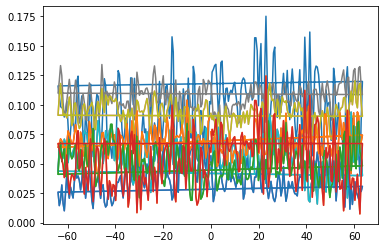

C:\Users\seanh\AppData\Local\Temp\ipykernel_14120\1635963209.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Xfft[i] = fft(Xnew[i])


(1375, 244, 14)
Results for FFT + RandomForestClassifier

Confusion Matrix
[[47  5  2  1  1]
 [ 5 40  3  1  0]
 [ 1  7 55  7  2]
 [ 2  3  6 44  2]
 [ 0  0  0  2 39]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        56
           1       0.73      0.82      0.77        49
           2       0.83      0.76      0.80        72
           3       0.80      0.77      0.79        57
           4       0.89      0.95      0.92        41

    accuracy                           0.82       275
   macro avg       0.82      0.83      0.82       275
weighted avg       0.82      0.82      0.82       275

FPS: 9593.850667549263FPS




In [8]:
# FFT
timesteps = 244 
Xnew = np.transpose(X,(0,2,1)).copy()
# Get FFT values and perform transformation
yf = fft(Xnew[0])
xf = fftfreq(timesteps, 1 / 128)
# Show plot and save
plt.plot(xf, np.abs(yf))
plt.savefig('Figures/Fig4_FFTtransformedsample.svg',bbox_inches='tight')
plt.show()
Xfft = Xnew.copy()
# Perform fft for whole dataset
for i in range(0, trials):
    Xfft[i] = fft(Xnew[i])
channels_num = 14
# Reshaping the dataset to 2d from 3d
XfftNew = np.reshape(Xfft.copy(),(trials,timesteps*channels_num))
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(XfftNew,y,test_size=0.2,shuffle=True,stratify=y)
ynew = y_train-1
print(Xnew.shape)
# RandomForestClassifier model
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train,ynew)
tic = time.perf_counter()
predicted = model.predict(X_test)
toc = time.perf_counter()
timeTaken = toc-tic
timeTakenper = timeTaken/1325
FPSscore = 1/timeTakenper
# Exctract and save output metrics
output = "Results for FFT + RandomForestClassifier\n\n"
output = output + 'Confusion Matrix\n' + str(confusion_matrix(predicted,y_test-1)) +'\n'
output = output + str(classification_report(predicted,y_test-1)) + '\n'
output = output + "FPS: " + str(FPSscore) + "FPS\n\n"
print(output)
f = open("results.txt", "a")
f.write(output)
f.close()